In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

In [27]:
opt_data = pd.read_csv('data/opt_data.csv')
drift = pd.read_csv('data/drift_data.csv')
excursion_data = pd.read_csv('data/excursion_data.csv')

drift_data = drift.copy()

In [28]:
# Features (X) and target (y)
X = drift_data.drop(columns=['outcome'])
y = drift_data['outcome']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# K-Fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
def tune_and_evaluate_full(model, param_grid, name):
    # Grid Search for Best Params
    search = GridSearchCV(model, param_grid, cv=kfold, scoring="neg_mean_squared_error", verbose=0)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Error Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return best_model, rmse, mae, y_test, y_pred

In [30]:
def plot_results(models_data):
    # Prepare figures grouped by plot types
    fig_actual_pred, axes_actual_pred = plt.subplots(1, len(models_data), figsize=(16, 5))
    fig_residuals, axes_residuals = plt.subplots(1, len(models_data), figsize=(16, 5))
    fig_lift_chart, axes_lift_chart = plt.subplots(1, len(models_data), figsize=(16, 5))

    for idx, (name, (y_test, y_pred)) in enumerate(models_data.items()):
        # Actual vs Predicted
        ax = axes_actual_pred[idx]
        ax.scatter(y_test, y_pred, color='darkcyan', alpha=0.7)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle="--", linewidth=1)
        ax.set_title(f"Actual vs Predicted - {name}")
        ax.set_xlabel("Actual Values")
        ax.set_ylabel("Predicted Values")
        ax.grid()

        # Residual KDE
        residuals = y_test - y_pred
        sns.kdeplot(residuals, fill=True, color="steelblue", ax=axes_residuals[idx])
        axes_residuals[idx].set_title(f"Residual Distribution - {name}")
        axes_residuals[idx].set_xlabel("Residuals")
        axes_residuals[idx].grid()

        # Lift Chart
        df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
        df_results['Decile'] = pd.qcut(df_results['Predicted'], 10, labels=False, duplicates='drop')
        lift_chart = df_results.groupby('Decile')[['Actual', 'Predicted']].mean()
        lift_chart.plot(ax=axes_lift_chart[idx], marker='o')
        axes_lift_chart[idx].set_title(f"Lift Chart (Deciles) - {name}")
        axes_lift_chart[idx].set_xlabel("Predicted Deciles")
        axes_lift_chart[idx].set_ylabel("Values")
        axes_lift_chart[idx].grid()

    # Adjust layouts
    fig_actual_pred.tight_layout()
    fig_residuals.tight_layout()
    fig_lift_chart.tight_layout()

    plt.show()

In [31]:
models = {
    "Random Forest": (RandomForestRegressor(), {"n_estimators": [50, 100], "max_depth": [None, 10]}),
    "XGBoost": (XGBRegressor(), {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1]}),
    "Ridge Regression": (Ridge(), {"alpha": [0.1, 1, 10]})
}

models_data = {}
mae_results = {}
rmse_results = {}
best_models = {}

for name, (model, params) in models.items():
    print(f"--- Tuning and Evaluating {name} ---")
    best_model, rmse, mae, y_test, y_pred = tune_and_evaluate_full(model, params, name)
    models_data[name] = (y_test, y_pred)
    mae_results[name] = mae
    rmse_results[name] = rmse
    best_models[name] = best_model

--- Tuning and Evaluating Random Forest ---
--- Tuning and Evaluating XGBoost ---
--- Tuning and Evaluating Ridge Regression ---


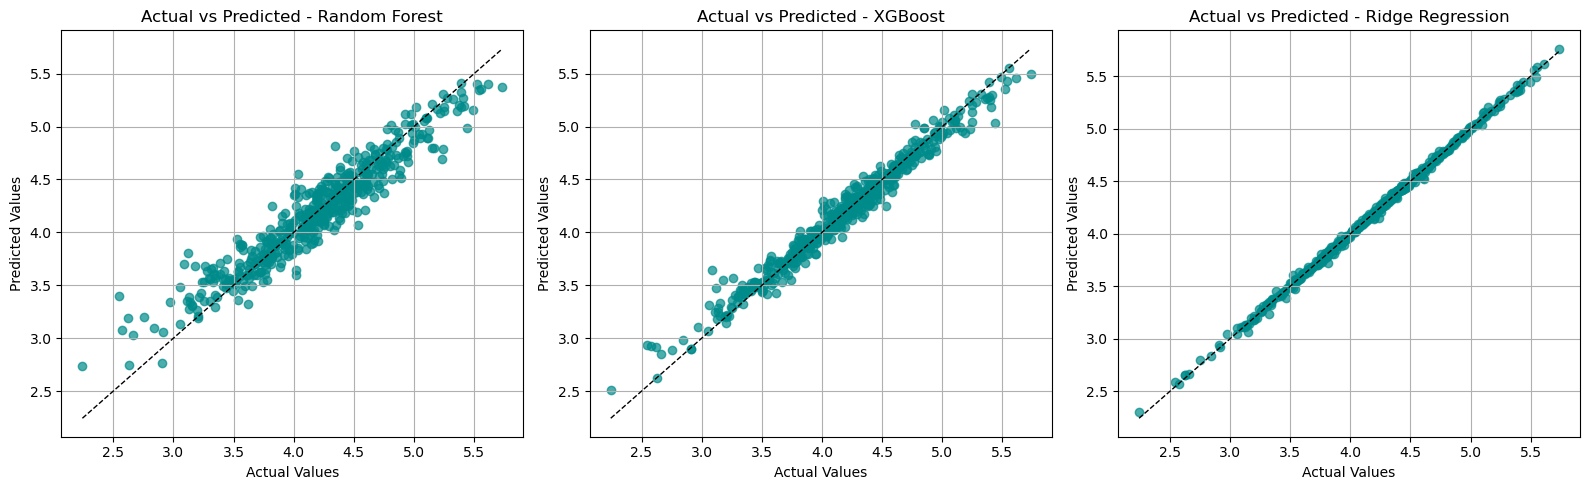

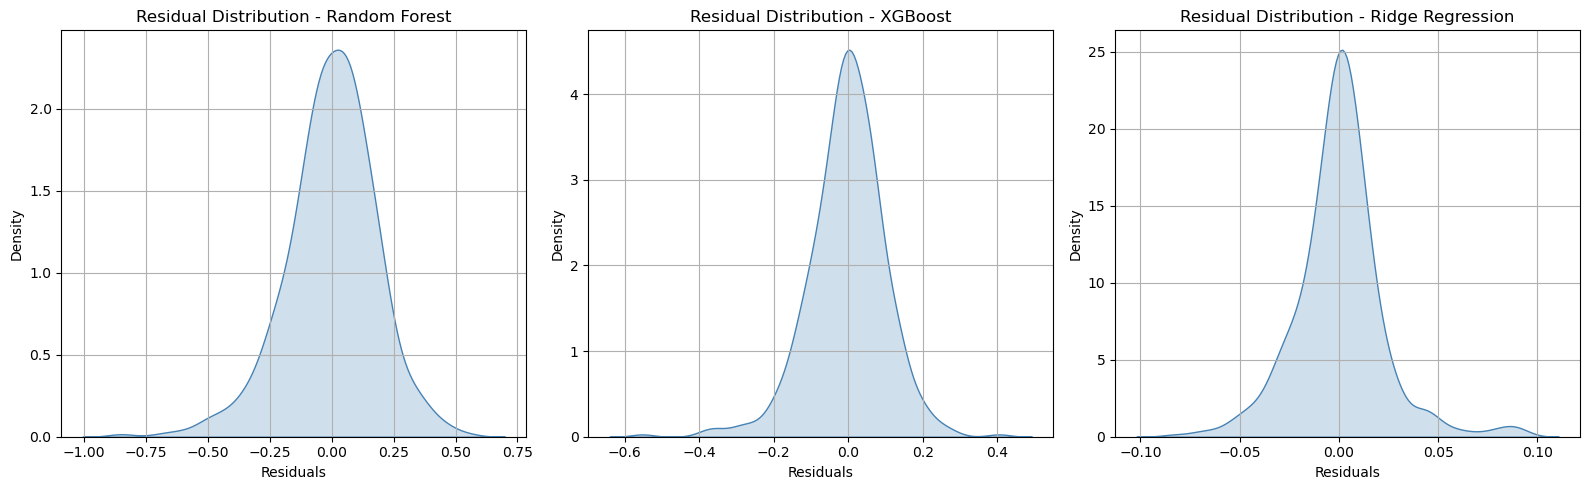

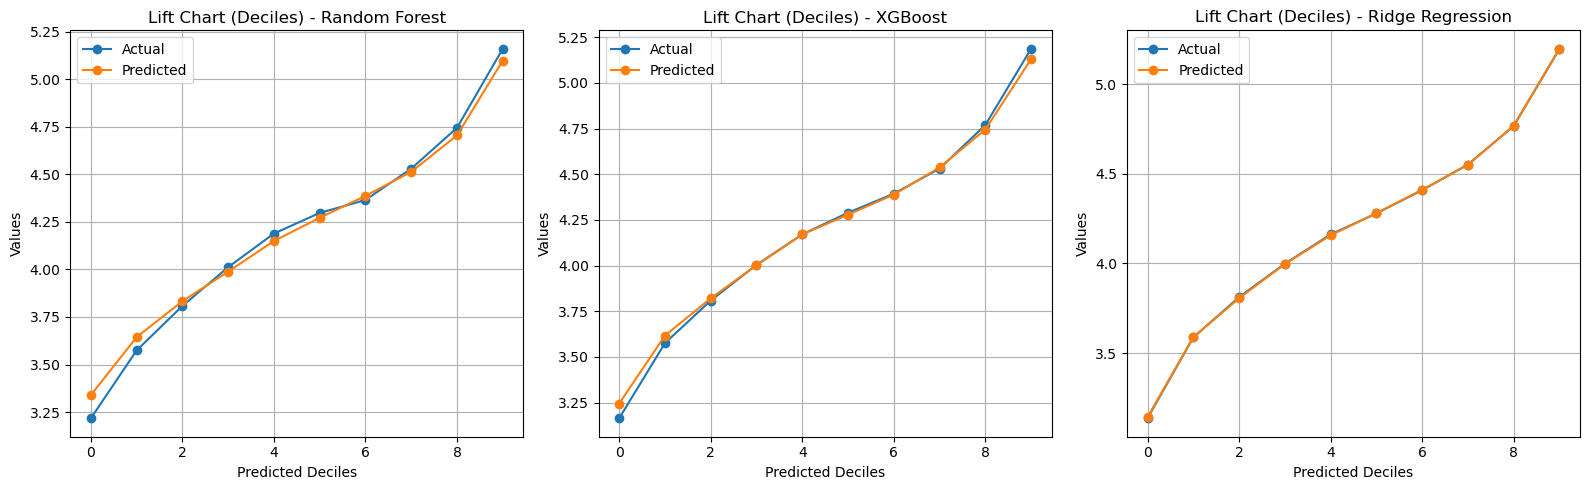

In [32]:
plot_results(models_data)

In [33]:
def compare_models(mae_results, rmse_results):
    metrics_df = pd.DataFrame({"Model": mae_results.keys(), "MAE": mae_results.values(), "RMSE": rmse_results.values()})
    metrics_df = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=metrics_df, x="Model", y="Score", hue="Metric", marker="o", palette="coolwarm")
    plt.title("Model Performance Comparison")
    plt.ylabel("Error Score")
    plt.xlabel("Models")
    plt.grid()
    plt.tight_layout()
    plt.show()

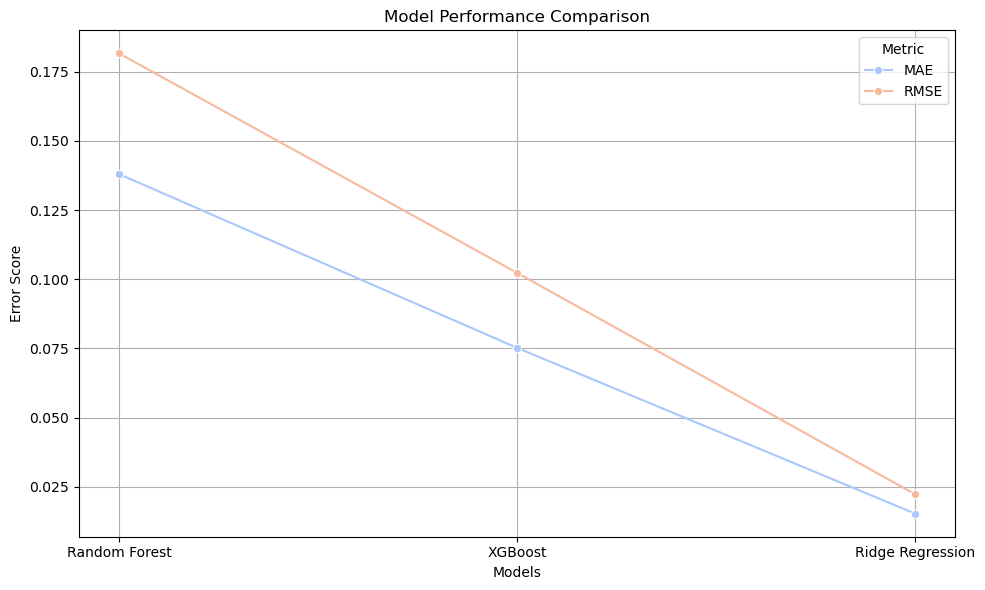

In [34]:
compare_models(mae_results, rmse_results)

In [35]:
best_model_name = min(rmse_results, key=rmse_results.get)
print(f"Best Model: {best_model_name}")

Best Model: Ridge Regression


In [36]:
def predict_and_evaluate_new_data(best_model, X_new, y_new, name):
    y_new_pred = best_model.predict(X_new)
    rmse = np.sqrt(mean_squared_error(y_new, y_new_pred))
    mae = mean_absolute_error(y_new, y_new_pred)
    r2 = r2_score(y_new, y_new_pred)
    print(f"Performance on {name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return y_new_pred

In [ ]:
excursion_predictions = predict_and_evaluate_new_data(
    best_models[best_model_name], 
    scaler.transform(excursion.drop(columns=['outcome'])), 
    excursion['outcome'], 
    'excursion'
)

In [38]:
train_columns = drift_data.drop(columns=['outcome']).columns

In [40]:
opt = opt_data.copy()
exc = excursion_data.copy()

In [43]:
for col in train_columns:
    if col not in opt:
        opt[col] = np.nan
    if col not in exc:
        exc[col] = np.nan

In [45]:
opt = opt[train_columns]
exc = exc[train_columns]

In [50]:
from sklearn.impute import SimpleImputer

# Define an imputer
imputer = SimpleImputer(strategy='mean')
X_drift = drift_data.drop(columns=['outcome'])
imputer.fit(X_drift)

SimpleImputer()

In [51]:
opt_filled = pd.DataFrame(imputer.transform(opt), columns=train_columns)
exc_filled = pd.DataFrame(imputer.transform(exc), columns=train_columns)

In [53]:
opt_scaled = scaler.transform(opt_filled)
exc_scaled = scaler.transform(exc_filled)

# Predict outcomes
opt_predictions = best_model.predict(opt_scaled)
exc_predictions = best_model.predict(exc_scaled)

# Add predictions to the original DataFrames
opt['predicted_outcome'] = opt_predictions
exc['predicted_outcome'] = exc_predictions

In [54]:
opt

,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,predicted_outcome
0,21.862886,44.076548,0.385464,153482.380172,1189.601769,84.749386,472.327432,5324.841768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.824076
1,21.936854,46.588398,0.387931,174425.755424,1173.213976,85.351092,436.442517,5770.244459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.697997
2,21.748247,43.924637,0.404794,145121.944106,1163.032806,83.522558,436.903823,5999.690636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.332062
3,22.240345,44.113534,0.373659,145268.279356,1182.199687,89.433775,474.883795,5441.928131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.209607
4,22.471606,45.282531,0.369017,146627.295171,1146.515675,85.760677,476.712633,5255.875803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.838071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,22.842059,45.720885,0.415925,146633.439090,1229.639256,82.471615,454.627825,5555.464271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.338113
4996,22.096666,43.619309,0.382873,163529.538859,1228.238934,85.620053,435.544340,5562.867636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.813681
4997,22.448479,43.546812,0.409153,154623.603744,1215.103692,80.922954,439.353636,5726.240538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.684595
4998,22.237098,43.589195,0.397781,140400.358985,1109.272426,78.004651,432.916171,6000.881838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.282281


In [5]:
def tune_and_evaluate(model, param_grid, name):
    search = GridSearchCV(model, param_grid, cv=kfold, scoring="neg_mean_squared_error", verbose=0)
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Error Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    # Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=30, color="coral")
    plt.title(f"Residuals for {name}")
    plt.xlabel("Prediction Error (Residual)")
    plt.show()
    
    return best_model, rmse, search.best_params_


# RF

Random Forest RMSE: 0.1572, R²: 0.9124


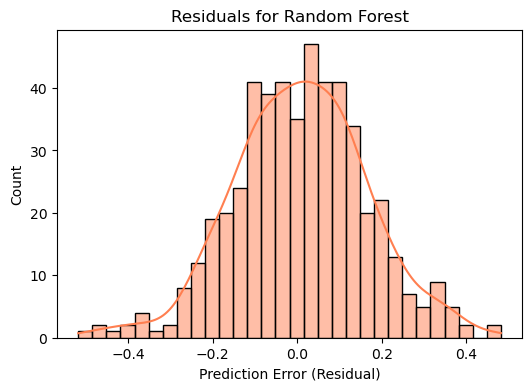

In [6]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_model, rf_rmse, rf_params = tune_and_evaluate(RandomForestRegressor(random_state=42), rf_param_grid, "Random Forest")


XGBoost RMSE: 0.0628, R²: 0.9860


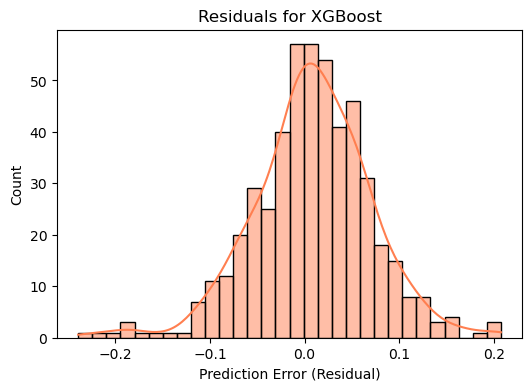

In [7]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

xgb_model, xgb_rmse, xgb_params = tune_and_evaluate(XGBRegressor(random_state=42), xgb_param_grid, "XGBoost")

Lasso Regression RMSE: 0.0365, R²: 0.9953


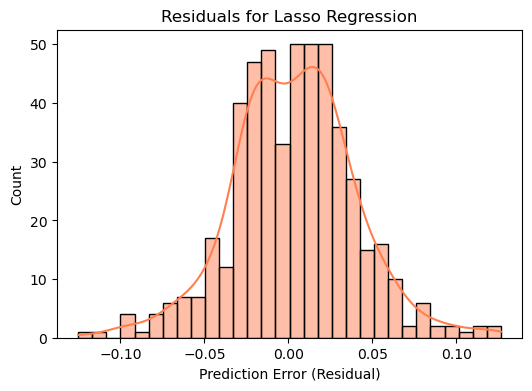

In [8]:
lasso_param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0]
}

lasso_model, lasso_rmse, lasso_params = tune_and_evaluate(Lasso(random_state=42), lasso_param_grid, "Lasso Regression")


C:\Users\hrith\AppData\Local\Temp\ipykernel_31548\3084980858.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rmse_results, x="Model", y="RMSE", palette="coolwarm")


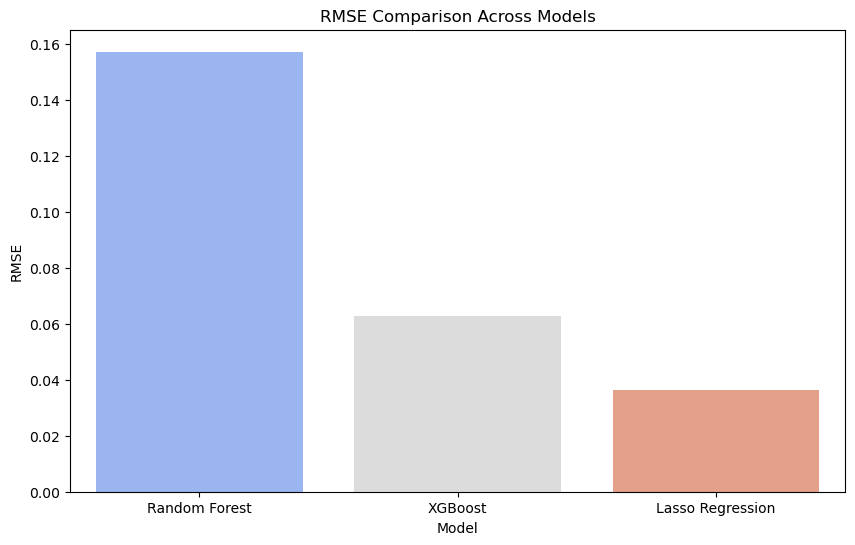

In [9]:
rmse_results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "Lasso Regression"],
    "RMSE": [rf_rmse, xgb_rmse, lasso_rmse]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=rmse_results, x="Model", y="RMSE", palette="coolwarm")
plt.title("RMSE Comparison Across Models")
plt.ylabel("RMSE")
plt.show()

C:\Users\hrith\AppData\Local\Temp\ipykernel_31548\3282739688.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importances.index, y=rf_importances.values, palette="viridis")


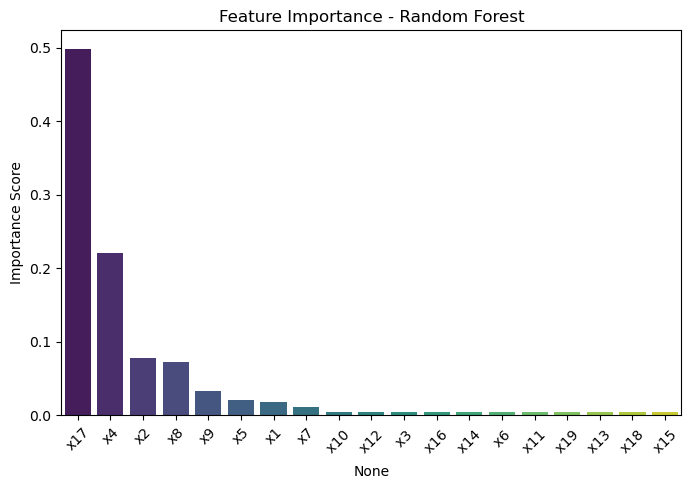

C:\Users\hrith\AppData\Local\Temp\ipykernel_31548\3282739688.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances.index, y=xgb_importances.values, palette="magma")


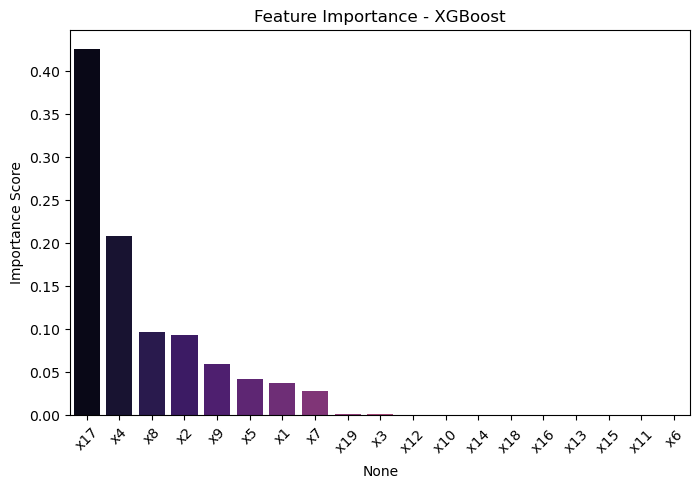

In [18]:
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
rf_importances = rf_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=rf_importances.index, y=rf_importances.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Feature Importance - Random Forest")
plt.ylabel("Importance Score")
plt.show()

# Sort and plot XGBoost Feature Importance
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
xgb_importances = xgb_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=xgb_importances.index, y=xgb_importances.values, palette="magma")
plt.xticks(rotation=45)
plt.title("Feature Importance - XGBoost")
plt.ylabel("Importance Score")
plt.show()

In [31]:
def tune_and_evaluate2(model, param_grid, name):
    # Cross-validation to find the best parameters
    search = GridSearchCV(model, param_grid, cv=kfold, scoring="neg_mean_squared_error", verbose=0)
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Error Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} RMSE: {rmse:.4f}, R²: {r2:.4f}")
    

    # Actual vs Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color="teal", alpha=0.6)
    plt.plot(y_test, y_test, color="black", linestyle="--")  # Perfect prediction line
    plt.title(f"Actual vs Predicted for {name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()
    plt.show()
    
    return best_model, rmse, r2

In [32]:
def compare_models(model_metrics):
    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(model_metrics).T
    metrics_df.columns = ["RMSE", "R²"]
    metrics_df = metrics_df.sort_values(by="RMSE")
    
    # Bar Plot for Model Comparison
    plt.figure(figsize=(10, 6))
    metrics_df.plot(kind='bar', color=['skyblue', 'orange'])
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

Random Forest RMSE: 0.1587, R²: 0.9107


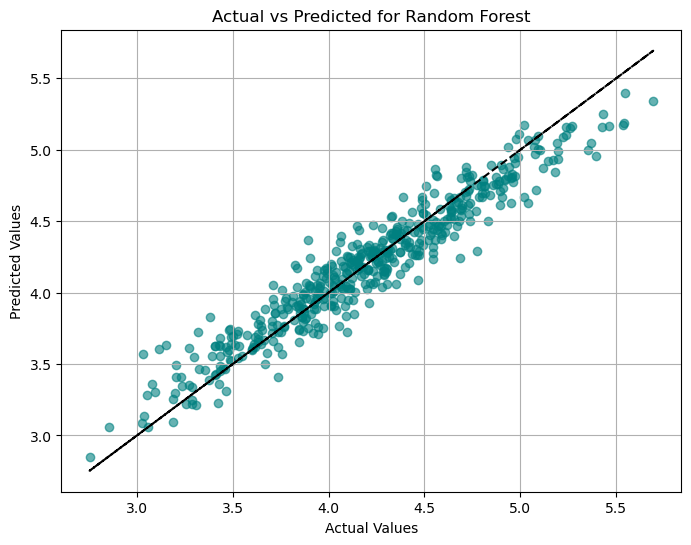

XGBoost RMSE: 0.0911, R²: 0.9706


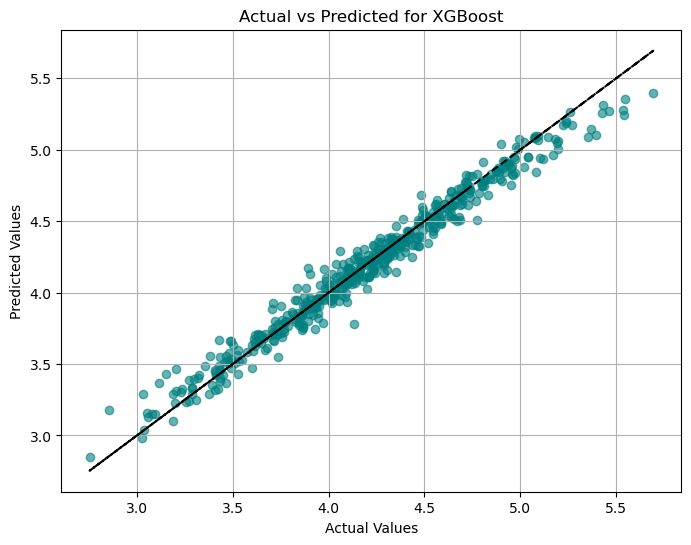

Ridge Regression RMSE: 0.0253, R²: 0.9977


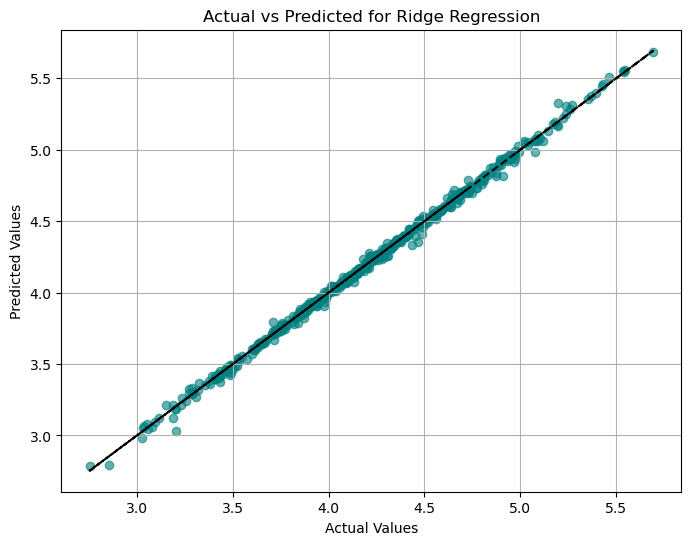

<Figure size 1000x600 with 0 Axes>

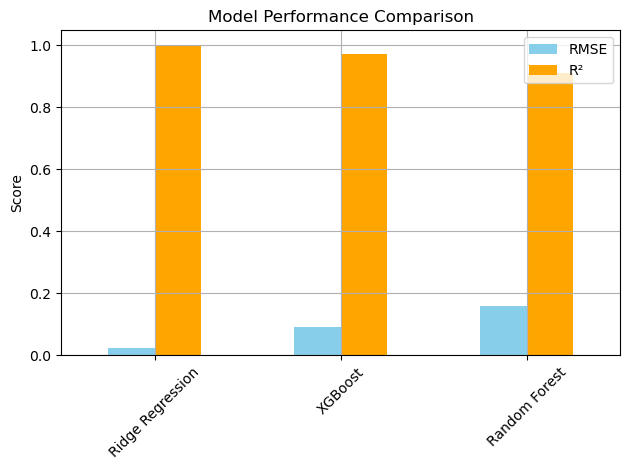

In [33]:
from sklearn.linear_model import Ridge


models = {
    "Random Forest": (RandomForestRegressor(), {"n_estimators": [50, 100], "max_depth": [None, 10]}),
    "XGBoost": (XGBRegressor(), {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1]}),
    "Ridge Regression": (Ridge(), {"alpha": [0.1, 1, 10]})
}

model_metrics = {}

# Train, Evaluate and Compare
for name, (model, params) in models.items():
    best_model, rmse, r2 = tune_and_evaluate2(model, params, name)
    model_metrics[name] = [rmse, r2]

# Compare Model Performance
compare_models(model_metrics)